In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/thefinaldataset/thefinal_dataset.csv


In [21]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"


In [22]:
import google.protobuf, click, os
print("protobuf:", google.protobuf.__version__)
print("click:", click.__version__)
print("NO_TF:", os.environ.get("TRANSFORMERS_NO_TF"))


protobuf: 5.29.5
click: 8.3.1
NO_TF: 1


/tmp/ipykernel_55/12450850.py:3: DeprecationWarning: The '__version__' attribute is deprecated and will be removed in Click 9.1. Use feature detection or 'importlib.metadata.version("click")' instead.
  print("click:", click.__version__)


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [24]:
df = pd.read_csv('/kaggle/input/thefinaldataset/thefinal_dataset.csv',encoding= 'unicode_escape')

In [25]:
df.head()

,text,status
0,"""My mind is a never-ending cycle of worry, and...",anxiety
1,Despite the sun shining and birds singing outs...,bipolar disorder
2,"I'm drowning in responsibilities, each one dem...",stress
3,"""My emotions shift like the wind, leaving me u...",personality disorder
4,"I'm trapped in a whirlwind of thoughts, unable...",anxiety


In [26]:
df.tail()

,text,status
474394,"What is this Life, exactly? I've got nearly ev...",suicidal
474395,So I just learned my uncle is dying I canât ...,suicidal
474396,I just keep getting worse I have been becoming...,suicidal
474397,My best friend wants to die...and as an occasi...,suicidal
474398,I'm going to kill my self in approximately 1 h...,suicidal


In [27]:
df.dropna(inplace=True)

In [28]:
df["status"].value_counts()

status
depression              144271
suicidal                 72892
adhd                     61705
bipolar disorder         36350
normal                   30201
ocd                      25367
ptsd                     21314
anxiety                  18693
stress                   16050
personality disorder     14810
aspergers                13418
schizophrenia             7682
addiction                 6561
alcoholism                5084
Name: count, dtype: int64

In [29]:
labels_list = sorted(df["status"].unique())   # or keep your own order if you want
label2id = {lbl:i for i,lbl in enumerate(labels_list)}
id2label = {i:lbl for lbl,i in label2id.items()}

df["label"] = df["status"].map(label2id)


In [30]:
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["status"],  # or "label"
    random_state=42
)


In [31]:
import numpy as np
import torch
from sklearn.utils.class_weight import compute_class_weight

y_train = train_df["label"].to_numpy()

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(len(labels_list)),
    y=y_train
)

class_weights = torch.tensor(class_weights, dtype=torch.float)
print("class_weights:", class_weights)


class_weights: tensor([5.1645, 0.5492, 6.6655, 1.8128, 2.5255, 0.9322, 0.2349, 1.1220, 1.3358,
        2.2880, 1.5898, 4.4107, 2.1112, 0.4649])


In [32]:
for i,w in enumerate(class_weights.tolist()):
    print(i, id2label[i], w)


0 addiction 5.164494037628174
1 adhd 0.5491538047790527
2 alcoholism 6.665460586547852
3 anxiety 1.8127877712249756
4 aspergers 2.525473117828369
5 bipolar disorder 0.9322018027305603
6 depression 0.23487378656864166
7 normal 1.1219911575317383
8 ocd 1.3357853889465332
9 personality disorder 2.2880172729492188
10 ptsd 1.5898438692092896
11 schizophrenia 4.410743236541748
12 stress 2.111248254776001
13 suicidal 0.4648779630661011


In [33]:
from datasets import Dataset

train_ds = Dataset.from_pandas(train_df[["text", "label"]].reset_index(drop=True))
val_ds   = Dataset.from_pandas(val_df[["text", "label"]].reset_index(drop=True))


In [34]:
from transformers import AutoTokenizer

MODEL_NAME = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

MAX_LEN = 256

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=MAX_LEN)

train_ds = train_ds.map(tokenize_fn, batched=True)
val_ds   = val_ds.map(tokenize_fn, batched=True)

train_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/379518 [00:00<?, ? examples/s]

Map:   0%|          | 0/94880 [00:00<?, ? examples/s]

In [35]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=14,
    id2label=id2label,
    label2id=label2id
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
from transformers import Trainer
import torch.nn as nn

class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(logits.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


In [37]:
from sklearn.metrics import f1_score

def compute_metrics(p):
    preds = p.predictions.argmax(-1)
    labels = p.label_ids
    return {
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }


In [38]:
from transformers import TrainingArguments

from transformers import TrainingArguments

args = TrainingArguments(
    output_dir="./bert_mh",
    eval_strategy="epoch",          # ✅ FIXED
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    logging_steps=100,
    report_to="none",
    fp16=True
)


trainer = WeightedTrainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)

trainer.train()


/tmp/ipykernel_55/2529020172.py:6: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,F1 Macro,F1 Weighted
1,0.569000,0.494548,0.813286,0.789865
2,0.572600,0.495773,0.837033,0.811915
3,0.258900,0.547782,0.842880,0.818477


TrainOutput(global_step=71160, training_loss=0.4397134694039922, metrics={'train_runtime': 27977.6866, 'train_samples_per_second': 40.695, 'train_steps_per_second': 2.543, 'total_flos': 1.4979921036338995e+17, 'train_loss': 0.4397134694039922, 'epoch': 3.0})

In [39]:
from sklearn.metrics import accuracy_score

pred = trainer.predict(val_ds)
y_true = pred.label_ids
y_pred = pred.predictions.argmax(-1)

acc = accuracy_score(y_true, y_pred)
print("Accuracy:", acc)


Accuracy: 0.8176011804384485


In [40]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=[id2label[i] for i in range(14)],
    digits=4
))


                      precision    recall  f1-score   support

           addiction     0.8031    0.8300    0.8163      1312
                adhd     0.9269    0.9096    0.9182     12341
          alcoholism     0.8054    0.8791    0.8406      1017
             anxiety     0.9278    0.9283    0.9281      3739
           aspergers     0.7290    0.7507    0.7397      2684
    bipolar disorder     0.8376    0.8323    0.8350      7270
          depression     0.8230    0.7083    0.7614     28854
              normal     0.9457    0.9570    0.9513      6040
                 ocd     0.8554    0.8874    0.8711      5073
personality disorder     0.9598    0.9429    0.9513      2962
                ptsd     0.7988    0.8288    0.8135      4263
       schizophrenia     0.7210    0.7943    0.7559      1536
              stress     0.9007    0.9103    0.9055      3210
            suicidal     0.6432    0.7985    0.7125     14579

            accuracy                         0.8176     94880
      

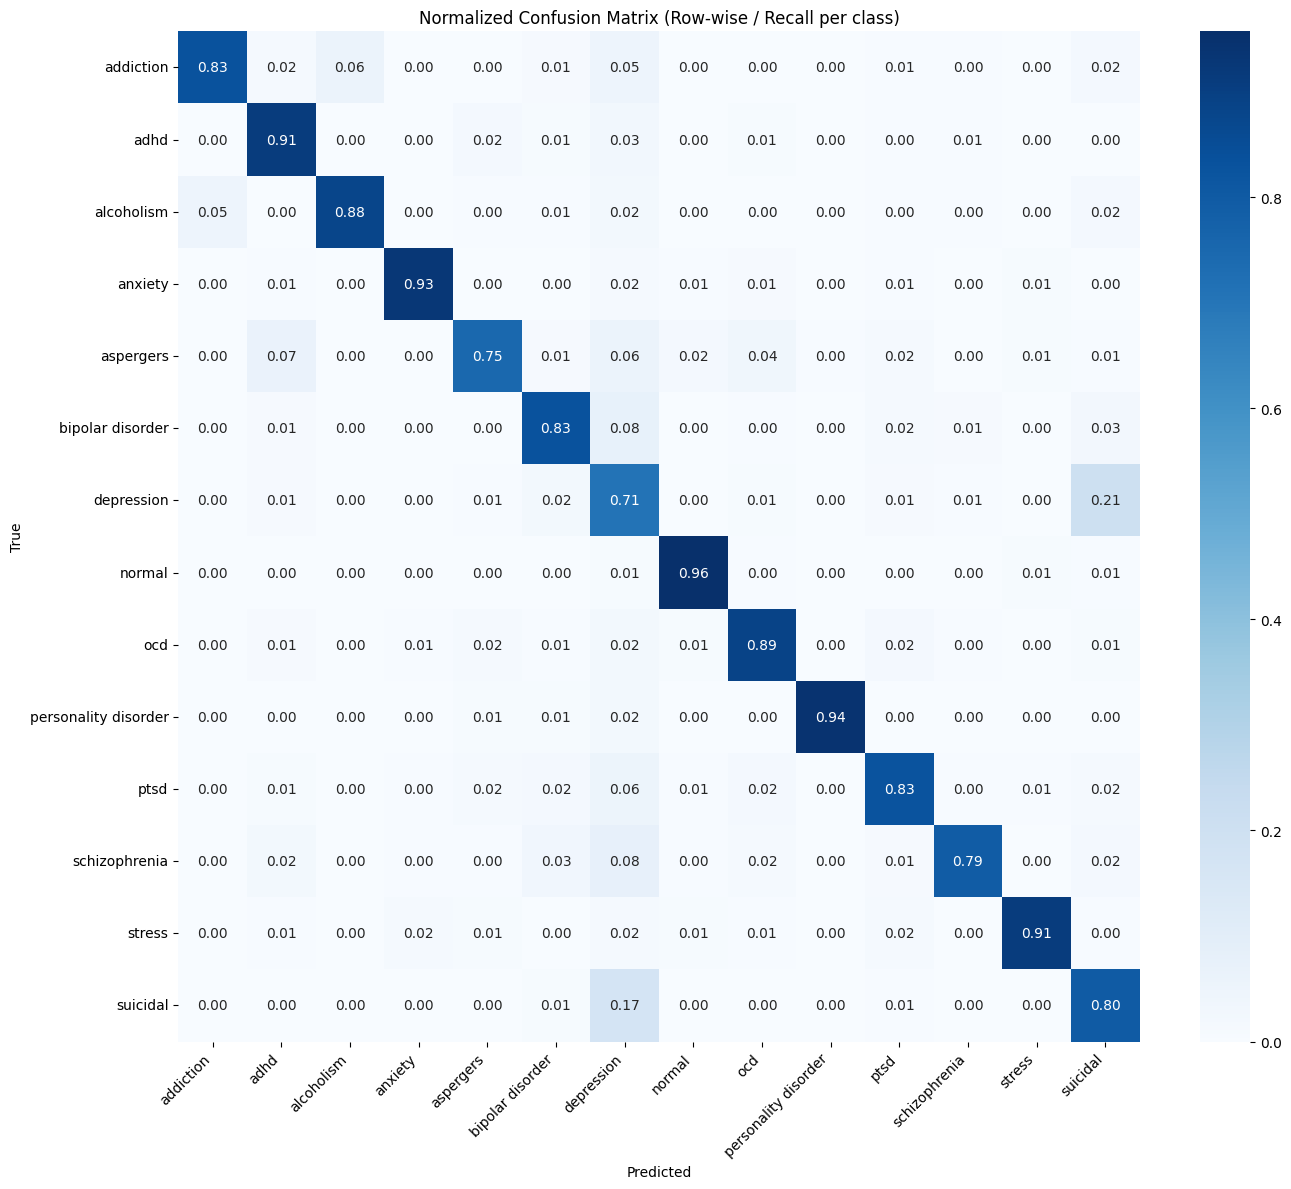

In [51]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Normalize by row (per true class)
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm_norm,
    xticklabels=id2label.values(),
    yticklabels=id2label.values(),
    cmap="Blues",
    annot=True,        # ✅ show numbers
    fmt=".2f",         # ✅ 2 decimals (percent-like)
    cbar=True
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (Row-wise / Recall per class)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


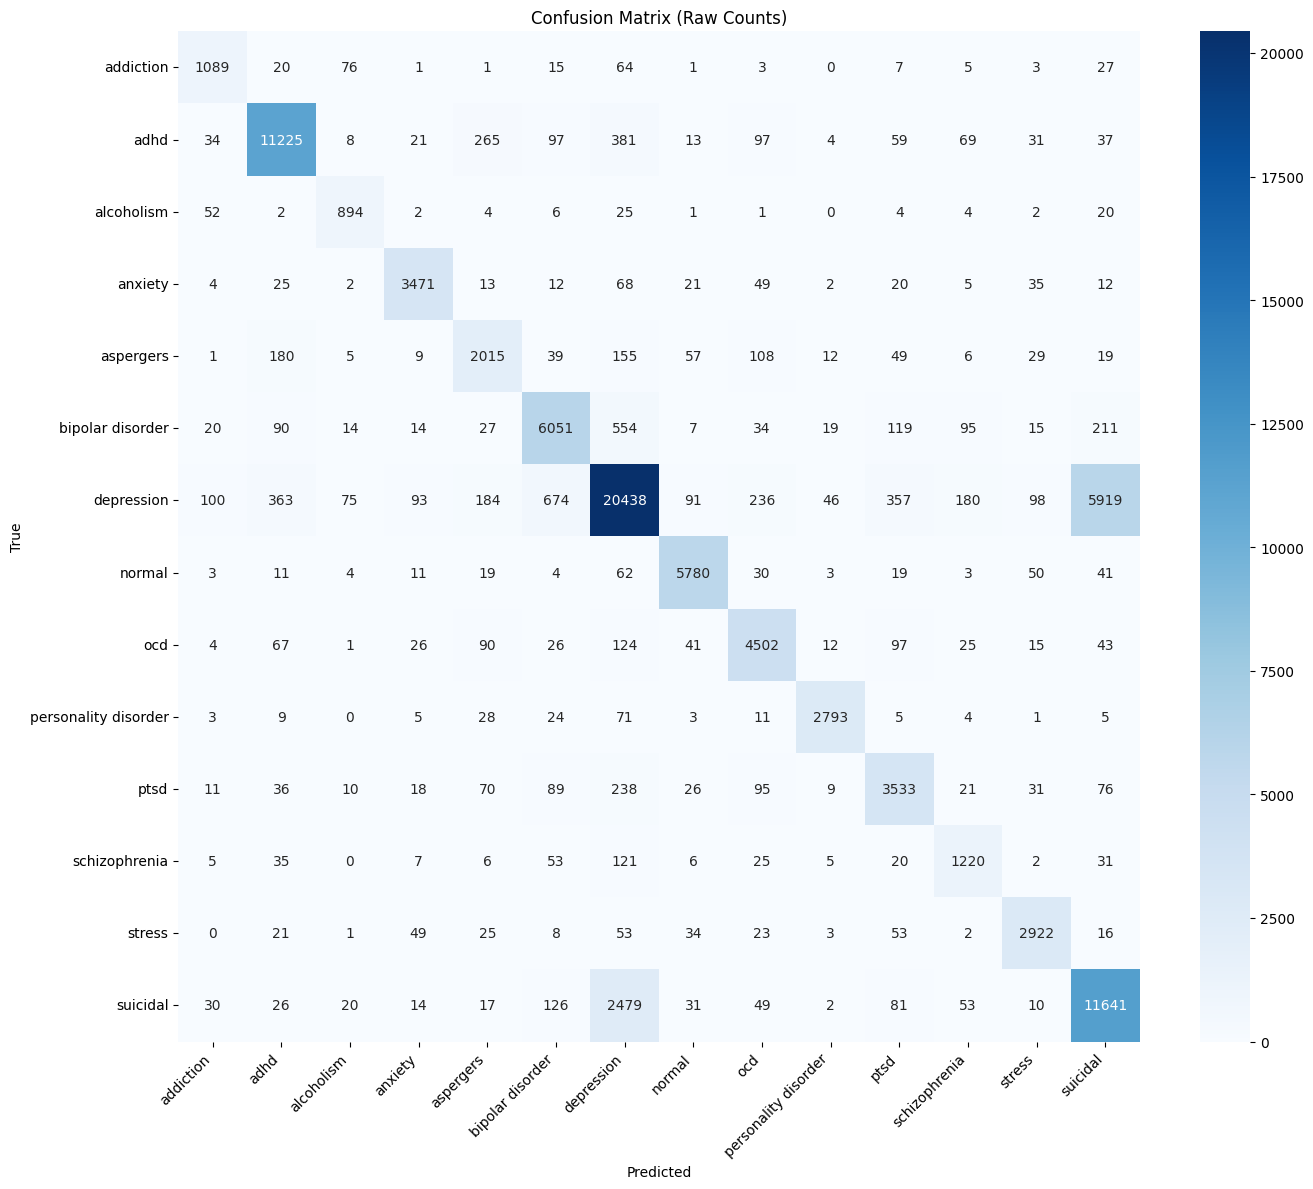

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute raw confusion matrix (counts)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(14, 12))
sns.heatmap(
    cm,
    xticklabels=id2label.values(),
    yticklabels=id2label.values(),
    cmap="Blues",
    annot=True,        # ✅ show numbers
    fmt="d",           # ✅ integers (counts)
    cbar=True
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Raw Counts)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [42]:
trainer.save_model("./best_bert_mh")
tokenizer.save_pretrained("./best_bert_mh")


('./best_bert_mh/tokenizer_config.json',
 './best_bert_mh/special_tokens_map.json',
 './best_bert_mh/vocab.txt',
 './best_bert_mh/added_tokens.json',
 './best_bert_mh/tokenizer.json')

In [45]:
from sklearn.metrics import classification_report

report = classification_report(
    y_true,
    y_pred,
    target_names=[id2label[i] for i in range(14)],
    digits=4,
    output_dict=True
)


In [47]:
import json

with open("evaluation_results.json", "w") as f:
    json.dump(report, f, indent=2)


In [48]:
text = "I feel hopeless and I don't want to live anymore"

inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(model.device)

with torch.no_grad():
    logits = model(**inputs).logits

pred_id = logits.argmax(-1).item()
print("Prediction:", id2label[pred_id])


Prediction: depression


In [53]:
!zip -r results.zip best_bert_mh evaluation_results.json confusion_matrix.png


	zip warning: name not matched: confusion_matrix.png
  adding: best_bert_mh/ (stored 0%)
  adding: best_bert_mh/config.json (deflated 56%)
  adding: best_bert_mh/special_tokens_map.json (deflated 42%)
  adding: best_bert_mh/training_args.bin (deflated 53%)
  adding: best_bert_mh/model.safetensors (deflated 7%)
  adding: best_bert_mh/tokenizer_config.json (deflated 75%)
  adding: best_bert_mh/tokenizer.json (deflated 71%)
  adding: best_bert_mh/vocab.txt (deflated 53%)
  adding: evaluation_results.json (deflated 68%)


In [54]:
!zip -r bert_mh_checkpoints.zip bert_mh


  adding: bert_mh/ (stored 0%)
  adding: bert_mh/checkpoint-47440/ (stored 0%)
  adding: bert_mh/checkpoint-47440/config.json (deflated 56%)
  adding: bert_mh/checkpoint-47440/optimizer.pt (deflated 14%)
  adding: bert_mh/checkpoint-47440/trainer_state.json (deflated 81%)
  adding: bert_mh/checkpoint-47440/rng_state.pth (deflated 26%)
  adding: bert_mh/checkpoint-47440/scheduler.pt (deflated 61%)
  adding: bert_mh/checkpoint-47440/special_tokens_map.json (deflated 42%)
  adding: bert_mh/checkpoint-47440/training_args.bin (deflated 53%)
  adding: bert_mh/checkpoint-47440/model.safetensors (deflated 7%)
  adding: bert_mh/checkpoint-47440/scaler.pt (deflated 64%)
  adding: bert_mh/checkpoint-47440/tokenizer_config.json (deflated 75%)
  adding: bert_mh/checkpoint-47440/tokenizer.json (deflated 71%)
  adding: bert_mh/checkpoint-47440/vocab.txt (deflated 53%)
  adding: bert_mh/checkpoint-23720/ (stored 0%)
  adding: bert_mh/checkpoint-23720/config.json (deflated 56%)
  adding: bert_mh/checkp

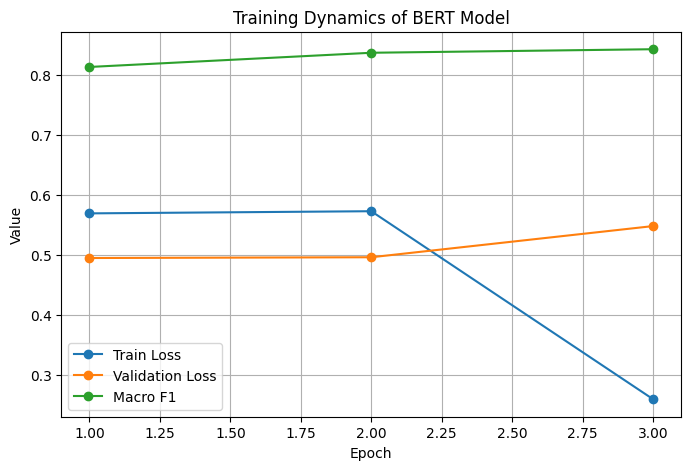

In [55]:
import matplotlib.pyplot as plt

epochs = [1, 2, 3]
train_loss = [0.5690, 0.5726, 0.2589]
val_loss = [0.4945, 0.4958, 0.5478]
f1_macro = [0.8133, 0.8370, 0.8429]

plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label="Train Loss", marker="o")
plt.plot(epochs, val_loss, label="Validation Loss", marker="o")
plt.plot(epochs, f1_macro, label="Macro F1", marker="o")

plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Dynamics of BERT Model")
plt.legend()
plt.grid(True)
plt.show()


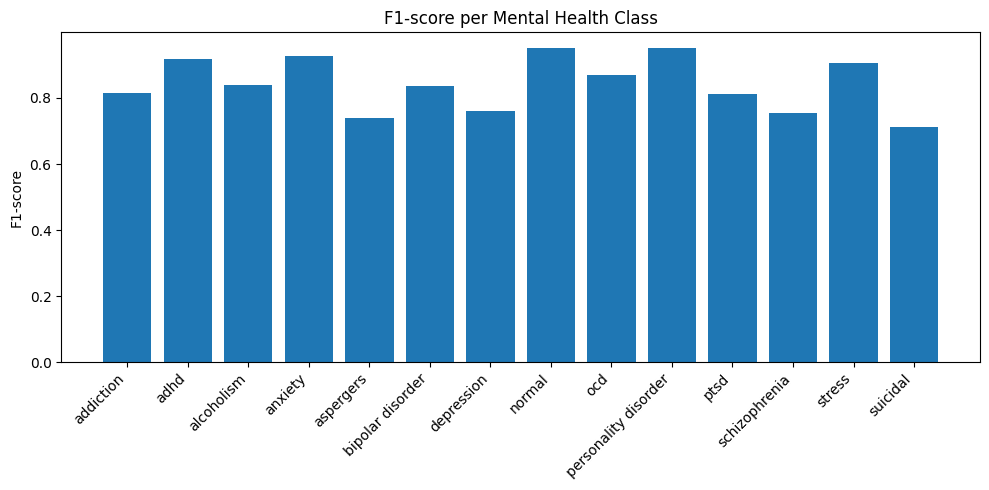

In [56]:
import matplotlib.pyplot as plt

labels = list(report.keys())[:-3]  # remove avg keys
f1_scores = [report[l]["f1-score"] for l in labels]

plt.figure(figsize=(10,5))
plt.bar(labels, f1_scores)
plt.xticks(rotation=45, ha="right")
plt.ylabel("F1-score")
plt.title("F1-score per Mental Health Class")
plt.tight_layout()
plt.show()
